Install required libaries.

In [55]:
# install required libraries
!pip install sdv # install the synthetic data vault library

In [56]:
!pip install pycaret

Import required libraries.

In [57]:
# import data science libraries
import pandas as pd
import numpy as np
import math

# import scikit-learn preprocessing
from sklearn.preprocessing import LabelEncoder, QuantileTransformer

# import pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# import synthetic data vault libraries
from sdv.metadata import SingleTableMetadata
import sdv.evaluation.single_table as sdv_st

# import utility libraries
from tqdm import tqdm
import xlrd
import requests
from io import BytesIO
from zipfile import ZipFile
from datetime import datetime

# import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

Init and set experiment parameters.

In [58]:
# set random seed
seed = 1234

# set dimension of categorical embeddings
cat_emb_dim = 2

# set number of neurons per layer
mlp_layers = [1024, 1024, 1024, 1024]

# set non-linear activation function
activation = 'lrelu'

# set number of diffusion steps
diffusion_steps = 500

# set diffusion start and end betas
diffusion_beta_start = 1e-4
diffusion_beta_end = 0.02

# set diffusion scheduler
scheduler = 'linear'

# set number of training epochs
epochs = 500

# set training batch size
batch_size = 512

# set training learning rate
learning_rate = 1e-4

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu").type

Set random seed values.

In [59]:
# set numpy seed
np.random.seed(seed)

# set pytorch seed
torch.manual_seed(seed)

# set cuda seed
torch.cuda.manual_seed(seed)

## Load, pre-process, and init the UCU Credit Card dataset
The dataset is available under https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.

In [60]:
# set data path
#data_url = 'https://archive.ics.uci.edu/static/public/519/heart+failure+clinical+records.zip'

# download the file
#response = requests.get(data_url)

# determine the zip file
#zip_file = ZipFile(BytesIO(response.content))

# extract the zip file
#zip_file.extractall('data')

# read the UCI credit card dataset
real_data = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')
test_data = pd.read_csv('/content/heart_failure_clinical_records_test_dataset.csv')
train_raw = pd.read_csv('/content/heart_failure_clinical_records_train_dataset.csv',header=0)

Inspect the top 10 rows and attribute names of the dataset retreived.

In [61]:
# display top 10 rows
train_raw.head(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.000,1,246,0,15,0,127000.00,1.20,137,1,0,10,1
1,75.000,0,99,0,38,1,224000.00,2.50,134,1,0,162,1
2,60.667,1,104,1,30,0,389000.00,1.50,136,1,0,171,1
3,52.000,0,132,0,30,0,218000.00,0.70,136,1,1,112,0
4,94.000,0,582,1,38,1,263358.03,1.83,134,1,0,27,1
5,68.000,1,220,0,35,1,289000.00,0.90,140,1,1,20,1
6,53.000,1,446,0,60,1,263358.03,1.00,139,1,0,215,0
7,70.000,1,75,0,35,0,223000.00,2.70,138,1,1,54,0
8,70.000,0,232,0,30,0,173000.00,1.20,132,1,0,210,0
9,55.000,1,170,1,40,0,336000.00,1.20,135,1,0,250,0


In [62]:
# Rename a single column
train_raw.rename(columns={'DEATH_EVENT': 'DEATHEVENT'}, inplace=True)
test_data.rename(columns={'DEATH_EVENT': 'DEATHEVENT'}, inplace=True)
real_data.rename(columns={'DEATH_EVENT': 'DEATHEVENT'}, inplace=True)

In [63]:
# display attribute names
train_raw.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATHEVENT'],
      dtype='object')

Set numerical and categorical dataset attributes.

In [64]:
# determine categorical attributes
cat_attrs = ['anaemia', 'diabetes', 'highbloodpressure', 'sex',	'smoking']

# determine numerical attributes
num_attrs = ['age', 'creatininephosphokinase', 'ejectionfraction', 'platelets', 'serumcreatinine', 'serumsodium', 'time']

Pre-process dataset attributes.

In [65]:
# remove underscore in column names for correct inverse decoding
train_raw.columns = [col.replace('_', '') for col in train_raw.columns]

# convert categorical attributes to string
train_raw[cat_attrs] = train_raw[cat_attrs].astype(str)

# iterate over categorical attributes
for cat_attr in cat_attrs:

    # add col name to every categorical entry to make them distinguishable for embedding
    train_raw[cat_attr] = cat_attr + '_' + train_raw[cat_attr].astype('str')

Set dataset label.

In [66]:
# extract label
label = train_raw['DEATHEVENT']

Determine the training data.

In [67]:
# merge selected categorical and numerical attributes
train = train_raw[[*cat_attrs, *num_attrs]]

In [68]:
train

,anaemia,diabetes,highbloodpressure,sex,smoking,age,creatininephosphokinase,ejectionfraction,platelets,serumcreatinine,serumsodium,time
0,anaemia_1,diabetes_0,highbloodpressure_0,sex_1,smoking_0,75.000,246,15,127000.00,1.20,137,10
1,anaemia_0,diabetes_0,highbloodpressure_1,sex_1,smoking_0,75.000,99,38,224000.00,2.50,134,162
2,anaemia_1,diabetes_1,highbloodpressure_0,sex_1,smoking_0,60.667,104,30,389000.00,1.50,136,171
3,anaemia_0,diabetes_0,highbloodpressure_0,sex_1,smoking_1,52.000,132,30,218000.00,0.70,136,112
4,anaemia_0,diabetes_1,highbloodpressure_1,sex_1,smoking_0,94.000,582,38,263358.03,1.83,134,27
...,...,...,...,...,...,...,...,...,...,...,...,...
234,anaemia_1,diabetes_1,highbloodpressure_1,sex_0,smoking_0,60.667,151,40,201000.00,1.00,136,172
235,anaemia_0,diabetes_1,highbloodpressure_0,sex_1,smoking_1,58.000,582,35,122000.00,0.90,139,71
236,anaemia_0,diabetes_0,highbloodpressure_0,sex_1,smoking_0,55.000,748,45,263000.00,1.30,137,88
237,anaemia_0,diabetes_1,highbloodpressure_1,sex_1,smoking_1,44.000,582,30,263358.03,1.60,130,244


Transform the numerical attributes.

In [69]:
# init the quantile transformation
num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)

# fit transformation to numerical attributes
num_scaler.fit(train[num_attrs])

# transform numerical attributes
train_num_scaled = num_scaler.transform(train[num_attrs])

Transform the categorical attributes.

In [70]:
# get vocabulary of categorical attributes
vocabulary_classes = np.unique(train[cat_attrs])

# init categorical attribute encoder
label_encoder = LabelEncoder()

# fit encoder to categorical attributes
label_encoder.fit(vocabulary_classes)

# transform categorical attributes
train_cat_scaled = train[cat_attrs].apply(label_encoder.transform)

# collect unique values of each categorical attribute
vocab_per_attr = {cat_attr: set(train_cat_scaled[cat_attr]) for cat_attr in cat_attrs}

Convert numerical and categorical attributes as well as the labels to tensors.

In [71]:
# convert numerical attributes
train_num_torch = torch.FloatTensor(train_num_scaled)

# convert categorical attributes
train_cat_torch = torch.LongTensor(train_cat_scaled.values)

# convert label
label_torch = torch.LongTensor(label)

Convert dataset to tensor dataset.

In [72]:
# init tensor dataset
train_set = TensorDataset(
    train_cat_torch, # categorical attributes
    train_num_torch, # numerical attributes
    label_torch # dataset labels
)

Init the data loader.

In [73]:
# init the data loader
dataloader = DataLoader(
    dataset=train_set, # training dataset
    batch_size=batch_size, # training batch size
    num_workers=0, # number of workers
    shuffle=True # shuffle training data
)

## Implement the FinDiff model

Implement the FinDiff backbone model.

In [74]:
# define base feedforward network
class BaseNetwork(nn.Module):

    # define base network constructor
    def __init__(self, hidden_size, activation='lrelu'):

        # call super calass constructor
        super(BaseNetwork, self).__init__()

        # init
        self.layers = self.init_layers(hidden_size)

        # case: lrelu activation
        if activation == 'lrelu':

            # set lrelu activation
            self.activation = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # case: relu activation
        elif activation == 'relu':

            # set relu activation
            self.activation = nn.ReLU(inplace=True)

        # case: tanh activation
        elif activation == 'tanh':

            # set tanh activation
            self.activation = nn.Tanh()

        # case: sigmoid activation
        else:

            # set sigmoid activation
            self.activation = nn.Sigmoid()

    # define layer initialization
    def init_layers(self, layer_dimensions):

        # init layers
        layers = []

        # iterate over layer dimensions
        for i in range(len(layer_dimensions)-1):

            # init linear layer
            layer = nn.Linear(layer_dimensions[i], layer_dimensions[i + 1], bias=True)

            # init linear layer weights
            nn.init.xavier_uniform_(layer.weight)

            # init linear layer bias
            nn.init.constant_(layer.bias, 0.0)

            # collecet linear layer
            layers.append(layer)

            # register linear layer parameters
            self.add_module('linear_' + str(i), layer)

        # return layers
        return layers

    # define forward pass
    def forward(self, x):

        # iterate over layers
        for i in range(len(self.layers)):

            # run layer forward pass
            x = self.activation(self.layers[i](x))

        # return forward pass result
        return x

Implement the FinDiff model synthesizer.

In [75]:
# define MLP synthesizer network
class MLPSynthesizer(nn.Module):

    # define MLP synthesizer network constructor
    def __init__(
            self,
            d_in: int,
            hidden_layers: list,
            activation: str='lrelu', # layer activation
            dim_t: int=64,
            n_cat_tokens=None, # number of categorical tokens
            n_cat_emb=None, # number of categorical dimensions
            embedding=None,
            embedding_learned=True,
            n_classes=None
        ):

        # call super class constructor
        super(MLPSynthesizer, self).__init__()

        # init ???
        self.dim_t = dim_t

        # init synthesizer base feed forward network
        self.backbone = BaseNetwork([dim_t, *hidden_layers], activation=activation)

        # case: categorical embedding defined
        if embedding is not None:

            # init pretrained embedding layer
            self.cat_embedding = nn.Embedding.from_pretrained(embeddings=embedding)

        # case: categorical embedding undefined
        else:

            # init new categorical embedding layer
            self.cat_embedding = nn.Embedding(n_cat_tokens, n_cat_emb, max_norm=None, scale_grad_by_freq=False)

            # activate categorical embedding layer learning
            self.cat_embedding.weight.requires_grad = embedding_learned

        # case: data classes available
        if n_classes is not None:

            # init label embedding layer
            self.label_embedding = nn.Embedding(n_classes, dim_t)

        # define input data projection
        self.projection = nn.Sequential(
            nn.Linear(d_in, dim_t), # linear layer
            nn.SiLU(), # silu activation
            nn.Linear(dim_t, dim_t) # linear layer
        )

        # define time embedding projection
        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t), # linear layer
            nn.SiLU(), # silu activation
            nn.Linear(dim_t, dim_t) # linear layer
        )

        # define output data projection
        self.head = nn.Linear(hidden_layers[-1], d_in)

    # define sinusodial time step embedding
    def embed_time(self, timesteps, dim_out, max_period=10000):

        # half output dimension
        half_dim_out = dim_out // 2

        # determine tensor of frequencies
        freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half_dim_out, dtype=torch.float32) / half_dim_out)

        # push to compute device
        freqs = freqs.to(device=timesteps.device)

        # create timestep vs. frequency grid
        args = timesteps[:, None].float() * freqs[None]

        # creating the time embedding
        time_embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

        # case: odd output dimension
        if dim_out % 2:

            # append additional dimension
            time_embedding = torch.cat([time_embedding, torch.zeros_like(time_embedding[:, :1])], dim=-1)

        # return timestep embedding
        return time_embedding

    # get categorical embeddings
    def get_embeddings(self):

        # return categorical embeddings
        return self.cat_embedding.weight.data

    # perform categorical embedding
    def embed_categorical(self, x_cat):

        # perform categorical embedding
        x_cat_emb = self.cat_embedding(x_cat)

        # reshape embedding to original input
        x_cat_emb = x_cat_emb.view(-1, x_cat_emb.shape[1] * x_cat_emb.shape[2])

        # return categorical embedding
        return x_cat_emb

    # define forward pass
    def forward(self, x, timesteps, label=None):

        # init time embeddings
        time_emb = self.embed_time(timesteps, self.dim_t)

        # embedd time embeddings
        time_emb  = self.time_embed(time_emb )

        # case: data classes available
        if label is not None:

            # determine label embeddings
            time_label_emb = time_emb  + self.label_embedding(label)

        # run initial projection layer
        x = self.projection(x)

        # add time and label embedding
        x = x + time_label_emb

        # run backbone forward pass
        x =  self.backbone(x)

        # run projection forward pass
        x = self.head(x)

        # return forward pass result
        return x

Implement the FinDiff model base diffuser.

In [76]:
# define BaseDiffuser network
class BaseDiffuser(object):

    # define base diffuser network constructor
    def __init__(
            self,
            total_steps=1000,
            beta_start=1e-4,
            beta_end=0.02,
            device='cpu',
            scheduler='linear'
        ):

        # set diffusion steps
        self.total_steps = total_steps

        # set diffusion start beta
        self.beta_start = beta_start

        # set diffusion end beta
        self.beta_end = beta_end

        # set compute device
        self.device = device

        # set noise schedule alphas and betas
        self.alphas, self.betas = self.prepare_noise_schedule(scheduler=scheduler)

        # set noise schedule alhpa hats
        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

    # define noise schedule
    def prepare_noise_schedule(self, scheduler: str):

        # determine noise scheduler scale
        scale = 1000 / self.total_steps

        # scale beta start
        beta_start = scale * self.beta_start

        # scale beta end
        beta_end = scale * self.beta_end

        # case: linear noise scheduler
        if scheduler == 'linear':

            # determine linear noise schedule betas
            betas = torch.linspace(beta_start, beta_end, self.total_steps)

            # determine linear noise schedule alphas
            alphas = 1.0 - betas

        # case: quadratic noise scheduler
        elif scheduler == 'quad':

            # determine quadratic noise schedule betas
            betas = torch.linspace(self.beta_start ** 0.5, self.beta_end ** 0.5, self.total_steps) ** 2

            # determine quadratic noise schedule alphas
            alphas = 1.0 - betas

        # return noise scheduler alphas and betas
        return alphas.to(self.device), betas.to(self.device)

    # define random timesteps sampler
    def sample_random_timesteps(self, n: int):

        # sample random timesteps
        t = torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

        # return random timesteps
        return t

    # define gaussian noise addition
    def add_gauss_noise(self, x_num, t):

        # determine noise alpha hat
        sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None]

        # determine noise one minius alpha hat
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None]

        # determine numeric noise
        noise_num = torch.randn_like(x_num)

        # determine x numeric noise
        x_noise_num = sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num

        # return x numeric noise and numeric noise
        return x_noise_num, noise_num

    # define gaussian noise sampling
    def p_sample_gauss(self, model_out, z_norm, timesteps):

        # determine noise alpha hat
        sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None]

        # determine noise betas
        betas_t = self.betas[timesteps][:, None]

        # determine noise one minius alpha hat
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None]

        epsilon_t = torch.sqrt(self.betas[timesteps][:, None])

        # determine random noise
        random_noise = torch.randn_like(z_norm)
        random_noise[timesteps == 0] = 0.0

        # determine model mean
        model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))

        # determine z norm
        z_norm = model_mean + (epsilon_t * random_noise)

        # return z norm
        return z_norm

## Initialize and train the FinDiff model

In [77]:
# determine number unique categorical tokens
n_cat_tokens = len(np.unique(train[cat_attrs]))

# determine total categorical embedding dimension
cat_dim = cat_emb_dim * len(cat_attrs)

# determine total numerical embedding dimension
num_dim = len(num_attrs)

# determine total embedding dimension
encoded_dim = cat_dim + num_dim

In [78]:
# initialize the FinDiff synthesizer model
synthesizer_model = MLPSynthesizer(
    d_in=encoded_dim,
    hidden_layers=mlp_layers,
    activation=activation,
    n_cat_tokens=n_cat_tokens,
    n_cat_emb=cat_emb_dim,
    n_classes=pd.Series(label).nunique(),
    embedding_learned=False
)

In [79]:
# initialize the FinDiff base diffuser model
diffuser_model = BaseDiffuser(
    total_steps=diffusion_steps,
    beta_start=diffusion_beta_start,
    beta_end=diffusion_beta_end,
    scheduler=scheduler,
    device=device
)

Init optimizer, scheduler and loss function.

In [80]:
# determine synthesizer model parameters
parameters = filter(lambda p: p.requires_grad, synthesizer_model.parameters())

# init Adam optimizer
optimizer = optim.Adam(parameters, lr=learning_rate)

# init learning rate scheduler
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=False)

# int mean-squared-error loss
loss_fnc = nn.MSELoss()

In [81]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
synthesizer_model.train()

# move to the device
synthesizer_model = synthesizer_model.to(device)

# init the training progress bar
pbar = tqdm(iterable=range(epochs), position=0, leave=True)

# iterate over training epochs
for epoch in pbar:

    base_params = {'epoch': epoch, 'seed': seed, 'mlp_layers': mlp_layers}

    # init epoch training batch losses
    batch_losses = []

    # iterate over epoch batches
    for batch_cat, batch_num, batch_y in dataloader:

        # move tensors to device
        batch_cat = batch_cat.to(device)
        batch_num = batch_num.to(device)
        batch_y = batch_y.to(device)

        # sample diffusion timestep
        timesteps = diffuser_model.sample_random_timesteps(n=batch_cat.shape[0])

        # determine categorical embeddings
        batch_cat_emb = synthesizer_model.embed_categorical(x_cat=batch_cat)

        # concatenate categorical and numerical embeddings
        batch_cat_num = torch.cat((batch_cat_emb, batch_num), dim=1)

        # add diffuser gaussian noise
        batch_noise_t, noise_t = diffuser_model.add_gauss_noise(x_num=batch_cat_num, t=timesteps)

        # conduct synthesizer model forward pass
        predicted_noise = synthesizer_model(x=batch_noise_t, timesteps=timesteps, label=batch_y)

        # compute training batch loss
        batch_loss = loss_fnc(input=noise_t, target=predicted_noise)

        # reset model gradients
        optimizer.zero_grad()

        # run model backward pass
        batch_loss.backward()

        # optimize model parameters
        optimizer.step()

        # collect training batch losses
        batch_losses.append(batch_loss.detach().cpu().numpy())

    # determine mean training epoch loss
    batch_losses_mean = np.mean(np.array(batch_losses))

    # update learning rate scheduler
    lr_scheduler.step()

    # collect mean training epoch loss
    train_epoch_losses.append(batch_losses_mean)

    # prepare and set training epoch progress bar update
    now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
    pbar.set_description('[LOG {}] epoch: {}, train-loss: {}'.format(str(now), str(epoch).zfill(4), str(batch_losses_mean)))


[LOG 2025-08-05 22:39:32] epoch: 0499, train-loss: 0.27554187: 100%|██████████| 500/500 [01:12<00:00,  6.94it/s]


Visualize training loss progression.

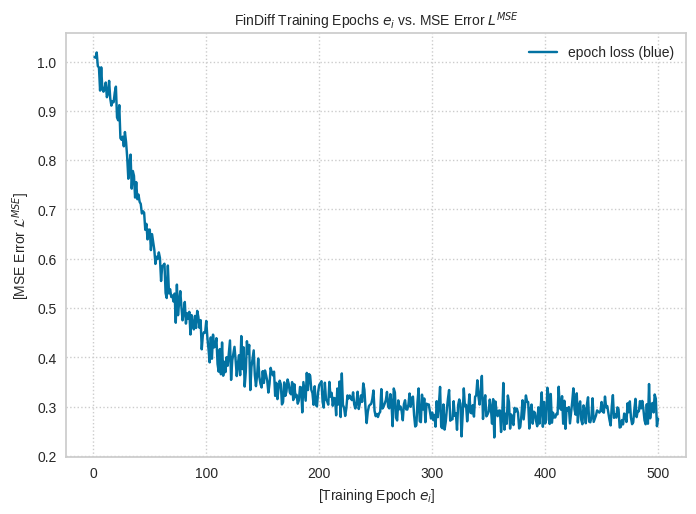

In [82]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel('[Training Epoch $e_i$]', fontsize=10)
ax.set_ylabel('[MSE Error $\mathcal{L}^{MSE}$]', fontsize=10)

# set plot legend
plt.legend(loc='upper right', numpoints=1, fancybox=True)

# add plot title
plt.title('FinDiff Training Epochs $e_i$ vs. MSE Error $L^{MSE}$', fontsize=10);

## Generate Data using the FinDiff model

Init and set sampling parameters.

Use FinDiff to generate new data samples.

In [83]:
# init samples to be generated
samples = torch.randn((len(label_torch), encoded_dim), device=device)

# init the generation progress bar
pbar = tqdm(iterable=reversed(range(0, diffusion_steps)), position=0, leave=True)

with torch.no_grad():
  # iterate over diffusion steps
  for diffusion_step in pbar:

      # prepare and set training epoch progress bar update
      now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
      pbar.set_description('[LOG {}] Diffusion Step: {}'.format(str(now), str(diffusion_step).zfill(4)))

      # init diffusion timesteps
      timesteps = torch.full((len(label_torch),), diffusion_step, dtype=torch.long, device=device)

      # run synthesizer model forward pass
      model_out = synthesizer_model(x=samples.float(), timesteps=timesteps, label=label_torch.to(device))

      # run diffuser model forward pass
      samples = diffuser_model.p_sample_gauss(model_out, samples, timesteps)


[LOG 2025-08-05 22:40:05] Diffusion Step: 0000: : 500it [00:31, 15.78it/s]


In [84]:
len(label_torch)

239

Decode generated FinDiff samples.

In [85]:
# split sample into numeric and categorical parts
samples = samples.detach().cpu().numpy()
samples_num = samples[:, cat_dim:]
samples_cat = samples[:, :cat_dim]

# denormalize numeric attributes
z_norm_upscaled = num_scaler.inverse_transform(samples_num)
z_norm_df = pd.DataFrame(z_norm_upscaled, columns=num_attrs)

# get embedding lookup matrix
embedding_lookup = synthesizer_model.get_embeddings().cpu()

# reshape back to batch_size * n_dim_cat * cat_emb_dim
samples_cat = samples_cat.reshape(-1, len(cat_attrs), cat_emb_dim)

# compute pairwise distances
distances = torch.cdist(x1=embedding_lookup, x2=torch.Tensor(samples_cat))

# get the closest distance based on the embeddings that belong to a column category
z_cat_df = pd.DataFrame(index=range(len(samples_cat)), columns=cat_attrs)

nearest_dist_df = pd.DataFrame(index=range(len(samples_cat)), columns=cat_attrs)

# iterate over categorical attributes
for attr_idx, attr_name in enumerate(cat_attrs):

    attr_emb_idx = list(vocab_per_attr[attr_name])
    attr_distances = distances[:, attr_emb_idx, attr_idx]

    nearest_values, nearest_idx = torch.min(attr_distances, dim=1)
    nearest_idx = nearest_idx.cpu().numpy()

    z_cat_df[attr_name] = np.array(attr_emb_idx)[nearest_idx]  # need to map emb indices back to column indices
    nearest_dist_df[attr_name] = nearest_values.cpu().numpy()

z_cat_df = z_cat_df.apply(label_encoder.inverse_transform)

samples_decoded = pd.concat([z_cat_df, z_norm_df], axis=1)

In [86]:
samples_decoded.head(10)

,anaemia,diabetes,highbloodpressure,sex,smoking,age,creatininephosphokinase,ejectionfraction,platelets,serumcreatinine,serumsodium,time
0,anaemia_1,diabetes_0,highbloodpressure_0,sex_0,smoking_0,40.0,582.000000,16.868784,249000.0000,0.800000,137.000000,145.000000
1,anaemia_0,diabetes_0,highbloodpressure_1,sex_0,smoking_0,72.0,326.379272,38.000000,252112.8750,1.600000,139.000000,186.000000
2,anaemia_1,diabetes_1,highbloodpressure_1,sex_1,smoking_1,65.0,336.664337,35.000000,302745.7500,2.100000,143.686035,14.232740
3,anaemia_1,diabetes_0,highbloodpressure_0,sex_1,smoking_1,60.0,60.383648,40.000000,218000.0000,1.400000,138.000000,205.283722
4,anaemia_1,diabetes_1,highbloodpressure_0,sex_1,smoking_1,55.0,61.000000,15.000000,606463.3750,1.336101,140.000000,13.251953
5,anaemia_1,diabetes_1,highbloodpressure_1,sex_1,smoking_1,60.0,582.000000,15.000000,742000.0000,1.300000,145.998337,54.050499
6,anaemia_1,diabetes_0,highbloodpressure_0,sex_1,smoking_1,40.0,4439.117188,20.000000,536944.2500,0.500028,129.000000,283.808228
7,anaemia_0,diabetes_0,highbloodpressure_1,sex_1,smoking_1,40.0,23.506409,15.000000,47002.6875,0.900000,145.681763,4.000000
8,anaemia_1,diabetes_0,highbloodpressure_0,sex_0,smoking_1,60.0,81.238251,30.000000,343217.5625,1.000000,139.000000,182.006119
9,anaemia_1,diabetes_0,highbloodpressure_1,sex_0,smoking_1,62.0,211.308990,40.000000,263638.5000,1.100000,138.000000,104.590424


## Evaluate the Generated Data

In [87]:
# build a metadata for evaluation (from SDV)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=train)

# generate quality report
quality_report = sdv_st.evaluate_quality(
    real_data=train,
    synthetic_data=samples_decoded,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 1128.71it/s]|
Column Shapes Score: 83.23%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 167.63it/s]|
Column Pair Trends Score: 80.29%

Overall Score (Average): 81.76%



In [88]:
# plot Column Shapes -> referred to the "Fidelity Column" in the paper
fig = quality_report.get_visualization(property_name='Column Shapes')
fig.show()

In [89]:
# plot Column Pair Trends -> referred to the "Fidelity Row" in the paper
fig = quality_report.get_visualization(property_name='Column Pair Trends')
fig.show()

In [90]:
samples_decoded['DEATHEVENT'] = label_torch.cpu().numpy()


In [91]:
import pandas as pd

# Assuming df is your DataFrame
samples_decoded.to_csv('/content/heart_failure_synthetic_diffusion.csv', index=False)

In [92]:
samples_decoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   anaemia                  239 non-null    object 
 1   diabetes                 239 non-null    object 
 2   highbloodpressure        239 non-null    object 
 3   sex                      239 non-null    object 
 4   smoking                  239 non-null    object 
 5   age                      239 non-null    float32
 6   creatininephosphokinase  239 non-null    float32
 7   ejectionfraction         239 non-null    float32
 8   platelets                239 non-null    float32
 9   serumcreatinine          239 non-null    float32
 10  serumsodium              239 non-null    float32
 11  time                     239 non-null    float32
 12  DEATHEVENT               239 non-null    int64  
dtypes: float32(7), int64(1), object(5)
memory usage: 17.9+ KB


In [93]:
samples_decoded['DEATHEVENT'].value_counts()

,count
DEATHEVENT,
0,168
1,71


In [94]:
df_synthetic = samples_decoded.copy()

In [95]:
df_real = train_raw.copy()

In [96]:
df_synthetic.head()

,anaemia,diabetes,highbloodpressure,sex,smoking,age,creatininephosphokinase,ejectionfraction,platelets,serumcreatinine,serumsodium,time,DEATHEVENT
0,anaemia_1,diabetes_0,highbloodpressure_0,sex_0,smoking_0,40.0,582.000000,16.868784,249000.000,0.800000,137.000000,145.000000,1
1,anaemia_0,diabetes_0,highbloodpressure_1,sex_0,smoking_0,72.0,326.379272,38.000000,252112.875,1.600000,139.000000,186.000000,1
2,anaemia_1,diabetes_1,highbloodpressure_1,sex_1,smoking_1,65.0,336.664337,35.000000,302745.750,2.100000,143.686035,14.232740,1
3,anaemia_1,diabetes_0,highbloodpressure_0,sex_1,smoking_1,60.0,60.383648,40.000000,218000.000,1.400000,138.000000,205.283722,0
4,anaemia_1,diabetes_1,highbloodpressure_0,sex_1,smoking_1,55.0,61.000000,15.000000,606463.375,1.336101,140.000000,13.251953,1


In [97]:
from pycaret.classification import *
s = setup(data=df_synthetic, target = 'DEATHEVENT', test_data=test_data, index=False, session_id = 123)

,Description,Value
0,Session id,123
1,Target,DEATHEVENT
2,Target type,Binary
3,Original data shape,"(299, 18)"
4,Transformed data shape,"(299, 13)"
5,Transformed train set shape,"(239, 13)"
6,Transformed test set shape,"(60, 13)"
7,Numeric features,12
8,Categorical features,5
9,Rows with missing values,100.0%


In [98]:
# functional API
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7993,0.7393,0.5482,0.7501,0.5935,0.4729,0.5011,0.0720
lda,Linear Discriminant Analysis,0.7951,0.7933,0.4821,0.7589,0.5675,0.4487,0.4796,0.0720
ridge,Ridge Classifier,0.7908,0.7941,0.4536,0.7506,0.5374,0.4247,0.4587,0.0730
lightgbm,Light Gradient Boosting Machine,0.7908,0.8166,0.5196,0.6917,0.5781,0.4496,0.4635,0.2790
lr,Logistic Regression,0.7868,0.8133,0.4964,0.7281,0.5628,0.4362,0.4654,1.0570
et,Extra Trees Classifier,0.7862,0.7887,0.4786,0.7100,0.5583,0.4294,0.4496,0.1960
rf,Random Forest Classifier,0.7824,0.8319,0.4643,0.6907,0.5398,0.4112,0.4311,0.2330
xgboost,Extreme Gradient Boosting,0.7779,0.8166,0.5054,0.6683,0.5460,0.4125,0.4291,0.1040
gbc,Gradient Boosting Classifier,0.7743,0.8022,0.5196,0.6370,0.5642,0.4177,0.4249,0.1790
ada,Ada Boost Classifier,0.7614,0.7390,0.5339,0.6469,0.5675,0.4076,0.4219,0.2550


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [99]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [100]:
from pycaret.classification import *
s_real = setup(df_real, target = 'DEATHEVENT', test_data=test_data, index=False, session_id = 1234)

,Description,Value
0,Session id,1234
1,Target,DEATHEVENT
2,Target type,Binary
3,Original data shape,"(299, 18)"
4,Transformed data shape,"(299, 13)"
5,Transformed train set shape,"(239, 13)"
6,Transformed test set shape,"(60, 13)"
7,Numeric features,12
8,Categorical features,5
9,Rows with missing values,100.0%


In [101]:
# functional API
best_real = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8871,0.9351,0.8036,0.8468,0.8128,0.7328,0.7430,0.3040
lightgbm,Light Gradient Boosting Machine,0.8623,0.9205,0.7339,0.8101,0.7520,0.6594,0.6735,0.6810
xgboost,Extreme Gradient Boosting,0.8580,0.9296,0.7357,0.8048,0.7442,0.6495,0.6689,0.1590
lda,Linear Discriminant Analysis,0.8576,0.8924,0.7196,0.8061,0.7489,0.6510,0.6621,0.0730
ridge,Ridge Classifier,0.8491,0.8924,0.6911,0.7963,0.7269,0.6250,0.6377,0.1100
ada,Ada Boost Classifier,0.8411,0.8667,0.6786,0.7895,0.7149,0.6076,0.6210,0.1530
et,Extra Trees Classifier,0.8409,0.9059,0.6089,0.8383,0.6954,0.5930,0.6127,0.2260
gbc,Gradient Boosting Classifier,0.8330,0.9079,0.7054,0.7744,0.6986,0.5910,0.6121,0.1810
lr,Logistic Regression,0.8152,0.8962,0.6482,0.7402,0.6745,0.5489,0.5622,0.1840
nb,Naive Bayes,0.8114,0.8627,0.5357,0.7364,0.6081,0.4946,0.5099,0.0740


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [102]:
evaluate_model(best_real)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [103]:
clf_setup = setup(
    data=df_real,
    target='DEATHEVENT',
    fix_imbalance=True,
    session_id=42,

)

,Description,Value
0,Session id,42
1,Target,DEATHEVENT
2,Target type,Binary
3,Original data shape,"(239, 13)"
4,Transformed data shape,"(306, 13)"
5,Transformed train set shape,"(234, 13)"
6,Transformed test set shape,"(72, 13)"
7,Numeric features,7
8,Categorical features,5
9,Preprocess,True


In [104]:
best_model_smote = compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8438,0.8932,0.7600,0.7250,0.7384,0.6274,0.6311,0.4670
rf,Random Forest Classifier,0.8382,0.9058,0.7600,0.7117,0.7311,0.6159,0.6201,0.3230
et,Extra Trees Classifier,0.8320,0.8844,0.6000,0.8000,0.6617,0.5581,0.5839,0.2040
lr,Logistic Regression,0.8261,0.8735,0.8000,0.6945,0.7300,0.6045,0.6220,0.2040
xgboost,Extreme Gradient Boosting,0.8254,0.9033,0.7200,0.7167,0.7104,0.5859,0.5922,0.1310
ridge,Ridge Classifier,0.8085,0.8750,0.8000,0.6689,0.7130,0.5739,0.5952,0.0790
lda,Linear Discriminant Analysis,0.8085,0.8750,0.8000,0.6689,0.7130,0.5739,0.5952,0.0780
gbc,Gradient Boosting Classifier,0.7956,0.8635,0.7400,0.6414,0.6826,0.5338,0.5408,0.1870
dt,Decision Tree Classifier,0.7949,0.7787,0.7400,0.6547,0.6820,0.5342,0.5466,0.0790
nb,Naive Bayes,0.7897,0.8435,0.7200,0.6444,0.6723,0.5200,0.5282,0.0800


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [105]:
evaluate_model(best_model_smote)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…